In [2]:
import numpy as np
import matplotlib.pyplot as plt

import librosa
import librosa.display
import pretty_midi_fluidsynth as pmf

import tensorflow as tf
from tensorflow import keras

import os
from functools import partial
from pathlib import Path

from sklearn.model_selection import train_test_split

# import data

In [3]:
context_description = {
    'hop_length':tf.io.FixedLenFeature([],tf.int64,
                                       default_value=0),
    'freq_width':tf.io.FixedLenFeature([],tf.int64,
                                       default_value=0),
    'octave':tf.io.FixedLenFeature([],tf.int64,
                                   default_value=0),
    'sampling_rate':tf.io.FixedLenFeature([],tf.int64,
                                          default_value=0),
    'piano_roll_fs':tf.io.FixedLenFeature([],tf.int64,
                                          default_value=0),
    'start_pitch': tf.io.FixedLenFeature([],tf.int64,
                                    default_value=0),
    'end_pitch':tf.io.FixedLenFeature([],tf.int64,
                                            default_value=0),
}

sequence_description = {
    'x': tf.io.FixedLenSequenceFeature([], tf.string),
    'y': tf.io.FixedLenSequenceFeature([], tf.string),
}

def _parse_function(example_proto):
  # Parse the input `tf.train.Example` proto using the dictionary above.
  return tf.io.parse_single_sequence_example(example_proto,
                                             context_description,
                                             sequence_description,)

In [4]:
filename = 'test_cqt-piano_roll.tfrecord'
path = os.path.join('./data',filename)

raw_ds = tf.data.TFRecordDataset(path)
parsed_ds = raw_ds.map(_parse_function)

In [5]:
for ds in parsed_ds.take(1):
    print(type(ds))
    context, sequence = ds

<class 'tuple'>


In [6]:
hop_len = int(context['hop_length'])
freq_w = int(context['freq_width'])
octave = int(context['octave'])

sr = int(context['sampling_rate'])
fs = int(context['piano_roll_fs'])

start_pitch = int(context['start_pitch'])
end_pitch = int(context['end_pitch'])

n_bins = 12*freq_w*octave
bins_per_octave = 12*freq_w

pr_n_bins = end_pitch - start_pitch

window = 400

In [7]:
def show_cqt(cqt):
    if cqt.ndim == 3:
        cqt = np.squeeze(cqt,-1)
    fig, ax = plt.subplots(1,1,figsize=(15,10))
    img = librosa.display.specshow(cqt, sr=sr,
                                   x_axis='time',
                                   y_axis='cqt_note',
                                   ax=ax,
                                   hop_length= hop_len,
                                   bins_per_octave= 12*freq_w,
                                   cmap='jet'
                                   )
    ax.set(title='Pitch axis decoration')
    fig.colorbar(img, ax=ax, format="%+2d")
    # for i in beat_times:
    #     ax.axvline(i,c='k')

    plt.show()

In [8]:
def show_pr(pr):
    if pr.ndim == 3:
        pr = np.squeeze(pr,-1)
    fig, ax = plt.subplots(1,1,figsize=(15,10))
    img = librosa.display.specshow(
        pr,
        hop_length=1,
        sr=fs,
        ax=ax,
        x_axis='time',
        y_axis='cqt_note',
        cmap='jet',
    #     fmin=pmf.note_number_to_hz(start_pitch),
#         vmin=0,
#         vmax=1,
    )
    fig.colorbar(img, ax=ax, format="%+2.2f")
    plt.show()

In [9]:
def show_3(cqt,pr,pred):
    show_list = [cqt,pr,pred]
    for i,s in enumerate(show_list):
        if s.ndim == 3:
            show_list[i] = np.squeeze(s,-1)
        elif s.ndim == 4:
            show_list[i] = np.squeeze(s,(0,-1))
    
    fig, ax = plt.subplots(1,3,figsize=(15,10))
    img0 = librosa.display.specshow(
        show_list[0].T, sr=sr,
        x_axis='time',
        y_axis='cqt_note',
        ax=ax[0],
        hop_length= hop_len,
        bins_per_octave= 12*freq_w,
        cmap='jet'
    )
    ax[0].set(title='constant-Q Transform')
    fig.colorbar(img0, ax=ax[0], format="%+2.2f")
    
    img1 = librosa.display.specshow(
        show_list[1].T,
        hop_length=1,
        sr=fs,
        ax=ax[1],
        x_axis='time',
        y_axis='cqt_note',
        cmap='jet',
    )
    ax[1].set(title='Piano roll form')
    fig.colorbar(img1, ax=ax[1], format="%+2.2f")
    
    img2 = librosa.display.specshow(
        show_list[2].T,
        hop_length=1,
        sr=fs,
        ax=ax[2],
        x_axis='time',
        y_axis='cqt_note',
        cmap='jet',
    )
    ax[2].set(title='Predict Piano roll form')
    fig.colorbar(img2, ax=ax[2], format="%+2.2f")
    plt.show()

In [10]:
def cqt_window(cqt):
    time = cqt.shape[1]
    if time < window:
        cqt = tf.pad(cqt,([0,0],[0,window-time],[0,0]))
    elif time > window:
        cqt = cqt[:,:window]
    return cqt

def pr_window(pr):
    time = pr.shape[1]
    if time < window//4:
        pr = tf.pad(pr,([0,0],[0,window//4-time],[0,0]))
    elif time > window//4:
        pr = pr[:,:window//4]
    pr = pr/255
    return pr

def load_cqt(data):
    raw = tf.io.decode_raw(data,tf.float32)
    cqt = tf.reshape(raw, [n_bins,-1,1])
    cqt = tf.py_function(cqt_window,[cqt],tf.float32)
    return tf.transpose(cqt,[1,0,2])

def load_piano_roll(data):
    raw = tf.io.decode_raw(data,tf.uint8)
    piano_roll = tf.reshape(raw, [pr_n_bins,-1,1])
    piano_roll = tf.py_function(pr_window,
                                [tf.cast(piano_roll,tf.float32)],
                                tf.float32)
    return tf.transpose(piano_roll,[1,0,2])

In [11]:
x_ds = tf.data.Dataset.from_tensor_slices(sequence['x'])
x_ds = x_ds.map(
    load_cqt,
#     num_parallel_calls=AUTOTUNE,
)
y_ds = tf.data.Dataset.from_tensor_slices(sequence['y'])
y_ds = y_ds.map(
    load_piano_roll,
#     num_parallel_calls=AUTOTUNE,
)
dataset = tf.data.Dataset.zip((x_ds,y_ds))
print(type(dataset))
print(len(dataset))

<class 'tensorflow.python.data.ops.dataset_ops.ZipDataset'>
180


# import model

In [11]:
model = tf.keras.models.load_model('./checkpoint/best_model')

# predict

In [12]:
idx = 1

In [13]:
list(dataset)[idx][0][tf.newaxis].shape

TensorShape([1, 400, 384, 1])

C:\Users\AI_server\miniconda3\envs\MA\lib\site-packages\librosa\util\decorators.py:88: UserWarning: Frequency axis exceeds Nyquist. Did you remember to set all spectrogram parameters in specshow?
  return f(*args, **kwargs)


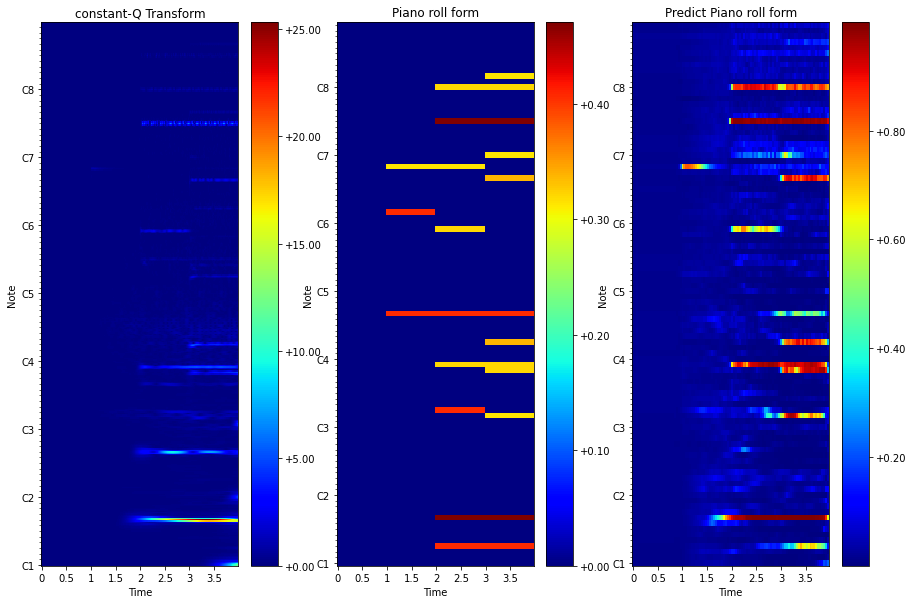

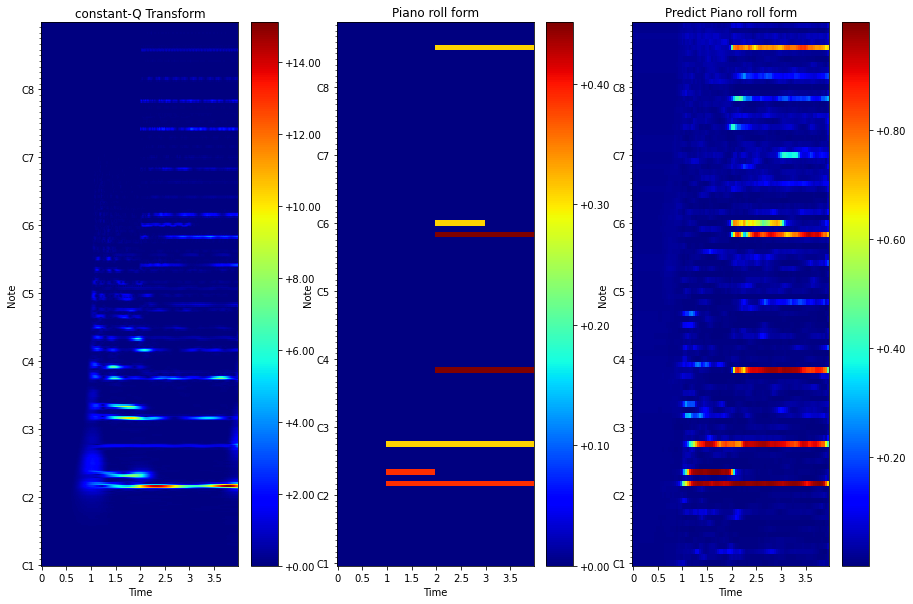

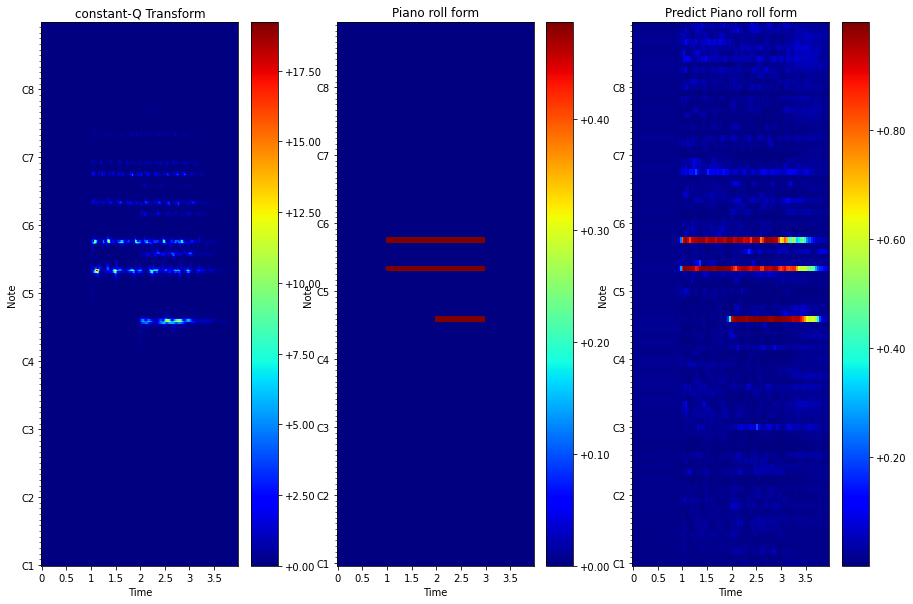

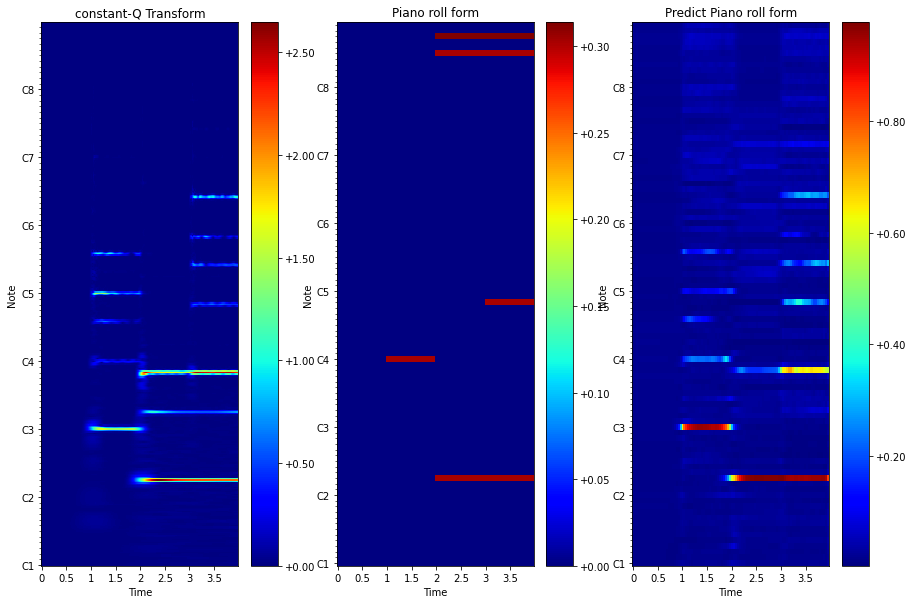

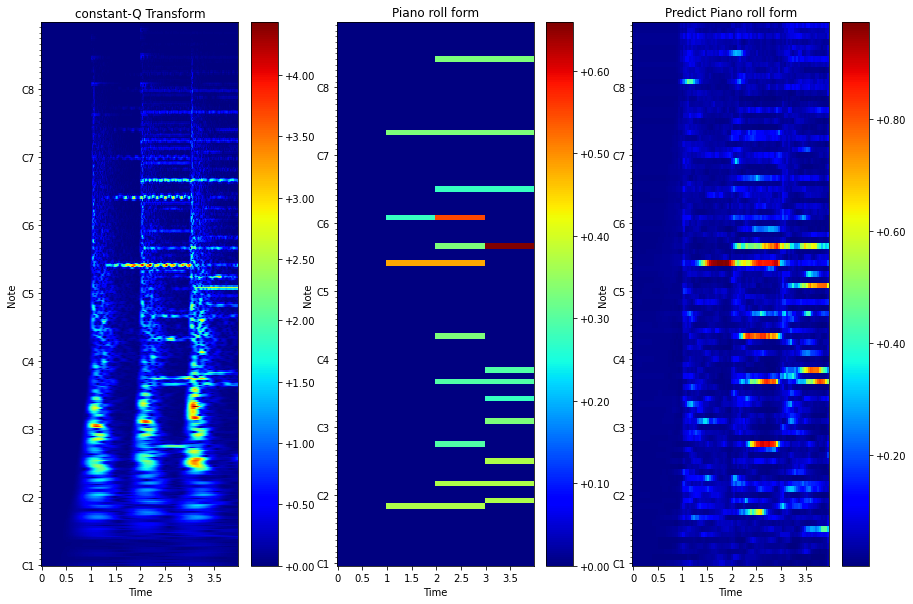

In [15]:
for cqt,pr in dataset.take(5):
    pred = model.predict(cqt[tf.newaxis])
    show_3(cqt,pr,pred)